In [1]:
from typing_extensions import TypedDict
from typing import Annotated ,NotRequired

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool,InjectedToolCallId,tool
from langgraph.prebuilt import InjectedState
from langchain.agents import create_agent
from langgraph.types import Command

from deep_agents_from_scratch.prompts import TASK_DESCRIPTION_PREFIX
from deep_agents_from_scratch.state import DeepAgentState

class SubAgent(TypedDict):
    name:str
    description:str
    prompt:str
    tool:NotRequired[list[str]]

def _create_tak_tool(tools,subagents:list[SubAgent],model,state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.
    
    This function implements the core pattern for spawning specialized sub-agents with
    isolated contexts ,preventing context clash and confusion in complex multi-step tasks.

    Args:
        tools:List of available tools that can be assigned to sub-agents.
        sub-agents:List of specialized sub-agent configurations
        model: The language model to use for all agents
        state_schema: The state schema (typically DeepAgentState)

    Returns:
        A 'task' toot that can delegate work to specialized sub-agents
    
    """

    agents = {}

    tools_by_name = {}

    for tool_ in tools:
        if not isinstance(tool_,BaseTool):
             tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    for _agent in subagents:
        if "tools" in _agent:
            _tools = [tools_by_name[t]for t in _agent["tools"]]
        else:
            _tools =tools
        agents[_agent['name']]=create_agent(
                model,
                system_prompt=_agent['prompt'] ,tools=tools ,state_schema=state_schema
            )

    other_agents_String =[
        f"-{_agent["name"]} : {_agent['description']}"for _agent in subagents
    ]


    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agent=other_agents_String))
    def task(
        description:str,
        subagent_type:str,
        state:Annotated[DeepAgentState,InjectedState],
        tool_call_id =Annotated[str,InjectedToolCallId]
    ):
        """ Delegate a task to specialized sub-agents with isolated context.
        
        This create a fresh context for the sub-agent containing only the task description,
        preventing context pollution from the parent agent's conversation history.
        """

        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type} ,  the only allowed types sre {[f'`{k}' for k in agents]}"
        
        sub_agent = agents[subagent_type]

        
        state["messages"] = [{"role": "user", "content": description}]

        result = sub_agent.invoke(state)

        
        return Command(
            update={
                "files": result.get("files", {}),  #
                "messages": [
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

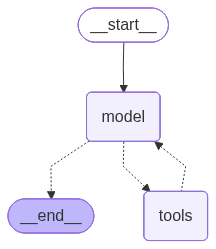

In [4]:
from datetime import datetime

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.agents import create_agent # updated in 1.0

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
import os


max_concurrent_research_units = 3
max_researcher_iterations = 3


search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from the search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# Create agent using create_react_agent directly
api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(model='gpt-4o-mini',api_key=api_key)

# Tools for sub-agent
sub_agent_tools = [web_search]

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# Tools
delegation_tools = [task_tool]

# Create agent with system prompt
agent = create_agent(
    model,
    delegation_tools,
    system_prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %d, %Y"),
    ),
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [5]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

In [6]:
result

{'messages': [HumanMessage(content='Give me an overview of Model Context Protocol (MCP).', additional_kwargs={}, response_metadata={}, id='30ae9249-c5a1-4d12-9f00-41fa4eb9d1ed'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 604, 'total_tokens': 643, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_644f11dd4d', 'id': 'chatcmpl-CrQ48WNeYZEbhFI0yUIbXRmIfGmhz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b6053-13ca-7832-9f18-741839efeaf2-0', tool_calls=[{'name': 'task', 'args': {'description': 'Provide an overview of Model Context Protocol (MCP) including its purpose, key components, and applications.', '